In [1]:
import pandas as pd
import sys
sys.path.append('../')
pd.options.mode.chained_assignment = None
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.cm as cmap
rc('font', **{'size':18})
%matplotlib inline
from multiprocessing import Pool
# from profilestats import profile
from scipy.stats import binned_statistic
from funcs.analysis.analysis import analysis
from os import listdir
import os
import time
from funcs.preprocessing.binning import bin_data
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
wdir = '/disk1/hrb/python/'
band = 'r'

# t_max w/o SSA = 6751 for qsos
# t_max w/o SSA = 7772 for stars
# config = {'obj':'qsos','ID':'uid'  ,'t_max':23576,'n_bins_t':200,'n_bins_m':200, 'n_bins_m2':248, 'n_t_chunk':20, 'width':2, 'steepness':0.005, 'leftmost_bin':-0.244}
config = {'obj':'calibStars','ID':'uid_s','t_max':25200,'n_bins_t':200,'n_bins_m':200, 'n_bins_m2':235,'n_t_chunk':20, 'width':1, 'steepness':0.005, 'leftmost_bin':-0.21}

width   = config['width']
steepness = config['steepness']
obj = config['obj']
ID  = config['ID']
t_max = config['t_max']
n_bins_t = config['n_bins_t']
n_bins_m = config['n_bins_m']
n_bins_m2 = config['n_bins_m2']
n_t_chunk = config['n_t_chunk']
leftmost_bin = config['leftmost_bin']

data_path = wdir+'data/computed/{}/dtdm/raw/{}/'.format(obj,band)

# sort based on filesize, then do ordered shuffle so that each core recieves the same number of large files
fnames = [a for a in listdir(data_path) if (len(a)>27)]
size=[]
for file in fnames:
    size.append(os.path.getsize(data_path+file))
    
fnames = [name for i in [0,1,2,3] for sizename, name in sorted(zip(size, fnames))[i::4]]

In [3]:
def reader(n_subarray):
    return pd.read_csv('../../data/merged/{}/r_band/with_ssa/lc_{}.csv'.format(obj,n_subarray), comment='#', nrows=None, index_col = ID, dtype = {'catalogue': np.uint8, 'mag_ps': np.float32, 'magerr': np.float32, 'mjd': np.float64, ID: np.uint32})

In [4]:
obj = 'calibStars'
ID  = 'uid_s'
redshift_bool = False
# obj = 'qsos'
# ID = 'uid'
# redshift_bool = True
band = 'r'
dr = analysis(ID, obj)

In [5]:
dr.read_in(reader, redshift=redshift_bool)
dr.band = band
dr.group(keys = [ID],read_in=True, redshift=redshift_bool, survey='all')

In [6]:
len(fnames)

200

In [19]:
fnames[195]

'dtdm_raw_r_725000_730000.csv'

In [28]:
fpath = data_path +'dtdm_raw_r_990000_995000.csv' 
df = pd.read_csv(fpath, index_col = ID, dtype = {ID: np.uint32, 'dt': np.float32, 'dm': np.float32, 'dm2_de2': np.float32, 'de': np.float32, 'cat': np.uint8});

In [29]:
df['dt'].max()

25197.258

In [10]:
%%bash -s "$fpath"
head -n 3 "$1"
echo '...'
tail -n 3 "$1"

uid_s,dt,dm,de,dm2_de2,cat
395001,5149.26171875,0.1557962639133308,0.28938794,-0.05947290687684026,15
395001,5502.27734375,0.10771963427466247,0.28920904,-0.07203834475111177,15
...
399998,2.00390625,-0.18334197998046875,0.04308176,0.03175824350910261,121
399998,4.015625,0.03814697265625,0.04594339,-0.0006556035950779915,121
399998,2.01171875,0.22148895263671875,0.043621372,0.047154531988780946,121


#########

In [ ]:
def correlate_mag_magerr_hist_sns(df, band, vmin, vmax, save=False):
    from matplotlib.colors import LogNorm
    import seaborn as sns
    xname = 'mag_mean'
    yname = 'dm'
    data = df
    bounds={xname:(16,22), yname:(-1,1)}
    g = sns.JointGrid(x=xname, y=yname, data=data, xlim=bounds[xname], ylim=bounds[yname], height=9,)
    g = g.plot_joint(plt.hexbin, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='Blues')
    g.ax_marg_x.hist(data[xname], bins=200)
    g.ax_marg_y.hist(data[yname], bins=200, orientation='horizontal', density = True)
#     g.ax_marg_y.hist(data[yname], bins=200, orientation='horizontal', cumulative=True, alpha=0.2, color='k')#, yticks=[1e-3, 1e-1, 1])
    # Could show 95, 99, 99.9% intervals on magerr histplot? Will need to do np.stats.quantile and ax.axvline
    q = [0.85,0.95,0.99]
    quantiles = zip(np.quantile(data[yname],q),q)
    for q_val,q in quantiles:
        g.ax_marg_y.axhline(y=q_val, lw=2, ls='--', color='k')
        g.ax_marg_y.text(y=q_val+0.003,x=0.8, s=f'{q*100:.0f}%: {q_val:.2f}', fontdict={'size':12}, horizontalalignment='center')
#     g.ax_marg_y.set(xscale='log')

#     plt.suptitle(self.name + ' ' + band, x=0.1, y=0.95)
    if save:
        g.savefig('{}/plots/mag_magerr_{}_{}.pdf'.format(self.obj, self.name, band))
        
correlate_mag_magerr_hist_sns(df, 'r', 1e2, 1e3)

#########

In [ ]:
# Snippet to find the max ∆t
dts = []
for fname in fnames:
    fpath = data_path + fname
    dt = pd.read_csv(fpath, usecols=['dt'], squeeze=True)
    dts.append(dt.max())

# bins

-2.00 < z < -1.00: 31,001
-1.00 < z < -0.50: 31,167
-0.50 < z < +0.00: 38,717
+0.00 < z < +0.50: 39,266
+0.50 < z < +1.00: 33,018
+1.00 < z < +2.00: 31,444


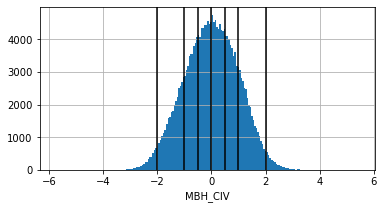

In [9]:
dr = analysis(ID, obj)
dr.properties = pd.read_csv(wdir+'data/catalogues/qsos/dr12q/SDSS_DR12Q_BH_matched.csv', index_col=dr.ID)
key = 'MBH_CIV'
prop_range_all = {'Mi':(-30,-20),'mag_mean':(15,23.5),'mag_std':(0,1),'redshift':(0,5),'Lbol':(44,48),'nEdd':(-3,0.5), 'MBH_CIV':(6,12)}
prop_range_any = {key:prop_range_all[key]}
# mask_all = np.array([(bound[0] < dr.properties[key]) & (dr.properties[key] < bound[1]) for key, bound in prop_range_all.items()])
mask_any  = np.array([(bound[0] < dr.properties[key]) & (dr.properties[key] < bound[1]) for key, bound in prop_range_any.items()])
mask = mask_any.any(axis=0)
dr.properties = dr.properties[mask]
# bounds_z = np.array([-2.5,-1.5,-1,-0.5,0,0.5,1,1.5,2.5])
bounds_z = np.array([-2,-1,-0.5,0,0.5,1,2])
bounds_tuple, z_score_val, bounds_values, mean, std, ax = dr.bounds(key, bounds = bounds_z)
z_score = z_score_val['z_score']

np.savetxt(wdir + 'data/computed/qsos/binned/{}/bounds_z.txt'.format(key), bounds_z, fmt='%.2f')
np.savetxt(wdir + 'data/computed/qsos/binned/{}/bounds_values.txt'.format(key), bounds_values)

groups = [z_score_val[(lower < z_score) & (z_score < upper)] for lower, upper in bounds_tuple]
for i, group in enumerate(groups):
    group.to_csv(wdir+'data/computed/{}/binned/{}/uids/group_{}.csv'.format(obj, key, i))

-2.00 < z < -1.00: 33,165
-1.00 < z < -0.50: 38,020
-0.50 < z < +0.00: 55,302
+0.00 < z < +0.50: 62,018
+0.50 < z < +1.00: 50,067
+1.00 < z < +2.00: 37,753


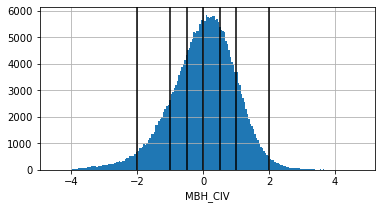

In [3]:
dr = analysis(ID, obj)
dr.properties = pd.read_csv(wdir+'data/catalogues/qsos/dr14q/dr14q_spec_prop_matched.csv', index_col=dr.ID)
key = 'MBH_CIV'
prop_range_all = {'Mi':(-30,-20),'mag_mean':(15,23.5),'mag_std':(0,1),'redshift':(0,5),'Lbol':(44,48),'nEdd':(-3,0.5), 'MBH_CIV':(6,12)}
prop_range_any = {key:prop_range_all[key]}
# mask_all = np.array([(bound[0] < dr.properties[key]) & (dr.properties[key] < bound[1]) for key, bound in prop_range_all.items()])
mask_any  = np.array([(bound[0] < dr.properties[key]) & (dr.properties[key] < bound[1]) for key, bound in prop_range_any.items()])
mask = mask_any.any(axis=0)
dr.properties = dr.properties[mask]
# bounds_z = np.array([-2.5,-1.5,-1,-0.5,0,0.5,1,1.5,2.5])
bounds_z = np.array([-2,-1,-0.5,0,0.5,1,2])
bounds_tuple, z_score_val, bounds_values, mean, std, ax = dr.bounds(key, bounds = bounds_z)
z_score = z_score_val['z_score']

np.savetxt(wdir + 'data/computed/qsos/binned/{}/bounds_z.txt'.format(key), bounds_z, fmt='%.2f')
np.savetxt(wdir + 'data/computed/qsos/binned/{}/bounds_values.txt'.format(key), bounds_values)

groups = [z_score_val[(lower < z_score) & (z_score < upper)] for lower, upper in bounds_tuple]
for i, group in enumerate(groups):
    group.to_csv(wdir+'data/computed/{}/binned/{}/uids/group_{}.csv'.format(obj, key, i))

In [7]:
dr.properties.columns

Index(['z', 'Mi', 'L5100', 'L5100_err', 'L3000', 'L3000_err', 'L1350',
       'L1350_err', 'MBH_MgII', 'MBH_CIV', 'Lbol', 'Lbol_err', 'nEdd',
       'sdss_name', 'ra', 'dec', 'z_score'],
      dtype='object')

In [7]:
def bin_chunks(indicies):
	dts_binned_tot = np.zeros((n_t_chunk,n_bins_t), dtype = 'int64')
	dms_binned_tot = np.zeros((n_t_chunk,n_bins_m), dtype = 'int64')
	des_binned_tot = np.zeros((n_t_chunk,n_bins_m), dtype = 'int64')
	dm2_de2_binned_tot = np.zeros((n_t_chunk,n_bins_m), dtype = 'int64') # This should stay as n_bins_m since we cut down the full array of length n_bins_m2
	dcat_tot = np.zeros((n_t_chunk,122), dtype = 'int64')
	boolean = lambda x: np.any([(x == cat) for cat in cat_list], axis=0)
	def boolean(df):
		if cat_list==0:
			# return whole dataframe if cat_list=0 (ie all)
			return df.values
		else:
			# return subset of dataframe for given survey pair
			return df[np.any([(df['cat'] == cat) for cat in cat_list], axis=0)].values
	for i in indicies:
		print('core {}: {}/{}'.format(int((i-lower) // (( upper-lower) / n_cores))+1, i-indicies[0], indicies[-1]-indicies[0] ))
		fpath = data_path+fnames[i]
		print(fpath)

#		 print('reading: {}\n'.format(fnames[i]))
		df = pd.read_csv(fpath, index_col = ID, dtype = {ID: np.uint32, 'dt': np.float32, 'dm': np.float32, 'de': np.float32, 'cat': np.uint8});
        ############################
#       # Uncomment if we are using a key
		#uid_uniq = df.index.unique()
		#sub_uids = uid_uniq[uid_uniq.isin(uids)]
		#df = df.loc[sub_uids]
        ##########################
        
        ############################
		# Uncomment if we are using a subset of uids
# 		uid_uniq = df.index.unique()
# 		sub_uids = uid_uniq[uid_uniq.isin(bright_uids)]
# 		df = df.loc[sub_uids]
        ##########################
        
		dtdms = boolean(df)
		dms_binned, dts_binned, des_binned, dm2_de2_binned, dcat = bin_data(dtdms, n_bins_t, n_bins_m, n_bins_m2, t_max, n_t_chunk, compute=True, steepness=steepness, width=width, leftmost_bin=leftmost_bin)
		dts_binned_tot += dts_binned.astype('int64')
		dms_binned_tot += dms_binned.astype('int64')
		dm2_de2_binned_tot += dm2_de2_binned.astype('int64')
		des_binned_tot += des_binned.astype('int64')
		dcat_tot	   += dcat.astype('int64')
        ########


	return dts_binned_tot, dms_binned_tot, dm2_de2_binned_tot, des_binned_tot, dcat_tot

In [8]:
lower   = 0
upper   = 200
n_cores = 4

# 200 files for stars, 104 for qsos

# t_bin_edges, t_bin_chunk, t_bin_chunk_centres, m_bin_edges, m_bin_centres, m_bin_widths, e_bin_edges, t_dict, m2_bin_edges, m2_bin_widths, m2_bin_centres = bin_data(None, n_bins_t, n_bins_m, n_bins_m2, t_max, n_t_chunk, steepness=steepness, width=width, compute=False)
indicies = np.array_split(np.arange(lower,upper), n_cores)

# cat_list_dict     = {'ssa_sdss':[1],'ssa_ps':[2],'ssa_ztf':[3],'sdss_sdss':[4],'sdss_ps':[5,7],'sdss_ztf':[6,10],'ps_ps':[8],'ps_ztf':[9,11],'ztf_ztf':[12]}#, 'all':0}
# cat_list_dict = {'sdss_sdss':[4],'ps_ps':[8],'ztf_ztf':[12]}
cat_list_dict = {'all':0}


In [9]:
# mag_cutoff = 19
# bright_uids = np.loadtxt('../data/computed/calibStars/binned/bright/mag_lt_19_uid_s.txt', dtype='uint64')

In [10]:
# For everything
for name, cat_list in cat_list_dict.items():
    start = time.time()
    if __name__ == '__main__':
        p = Pool(n_cores)
        result = p.map(bin_chunks, indicies);
    #     result = result.sum(axis=0)
    # print(np.array_s plit(np.arange(lower,upper),4))
    # bin_chunks(np.array_split(np.arange(lower,upper),4)[3]) 
    end = time.time()
    print('time taken: {:.2f} minutes'.format((end-start)/60.0))

    a, b, c, d = result # unpack each subresult from multiproc
    dtdmde_result = (np.array(a[:-1]) + np.array(b[:-1]) + np.array(c[:-1]) + np.array(d[:-1]))
    dcat_result  = a[-1] + b[-1] + c[-1] + d[-1]
    dts_binned_tot, dms_binned_tot, dm2_de2_binned_tot, des_binned_tot = dtdmde_result
    np.savetxt('../../data/computed/{}/binned/all/dc/dcs_binned_{}_{}.csv'.format(obj, obj, name), dcat_result, fmt='%i', delimiter=',')
    np.savetxt('../../data/computed/{}/binned/all/dt/dts_binned_{}_{}.csv'.format(obj, obj, name), dts_binned_tot, fmt='%i', delimiter=',')
    np.savetxt('../../data/computed/{}/binned/all/dm/dms_binned_{}_{}.csv'.format(obj, obj, name), dms_binned_tot, fmt='%i', delimiter=',')
    np.savetxt('../../data/computed/{}/binned/all/de/des_binned_{}_{}.csv'.format(obj, obj, name), des_binned_tot, fmt='%i', delimiter=',')
    np.savetxt('../../data/computed/{}/binned/all/dm2_de2/dm2_de2_binned_{}_{}.csv'.format(obj, obj, name), dm2_de2_binned_tot, fmt='%i', delimiter=',')

core 3: 0/49
core 4: 0/49/disk1/hrb/python/data/computed/calibStars/dtdm/raw/r/dtdm_raw_r_155000_160000.csv
core 2: 0/49core 1: 0/49
/disk1/hrb/python/data/computed/calibStars/dtdm/raw/r/dtdm_raw_r_040000_045000.csv

/disk1/hrb/python/data/computed/calibStars/dtdm/raw/r/dtdm_raw_r_035000_040000.csv/disk1/hrb/python/data/computed/calibStars/dtdm/raw/r/dtdm_raw_r_015000_020000.csv


core 1: 1/49
/disk1/hrb/python/data/computed/calibStars/dtdm/raw/r/dtdm_raw_r_345000_350000.csv
core 2: 1/49
/disk1/hrb/python/data/computed/calibStars/dtdm/raw/r/dtdm_raw_r_090000_095000.csv
core 3: 1/49
/disk1/hrb/python/data/computed/calibStars/dtdm/raw/r/dtdm_raw_r_305000_310000.csv
core 4: 1/49
/disk1/hrb/python/data/computed/calibStars/dtdm/raw/r/dtdm_raw_r_070000_075000.csv
core 1: 2/49
/disk1/hrb/python/data/computed/calibStars/dtdm/raw/r/dtdm_raw_r_265000_270000.csv
core 2: 2/49
/disk1/hrb/python/data/computed/calibStars/dtdm/raw/r/dtdm_raw_r_280000_285000.csv
core 3: 2/49
/disk1/hrb/python/data/comp

In [11]:
# If we have key
for name, cat_list in cat_list_dict.items():
    
    groups = [z_score[(lower < z_score) & (z_score < upper)] for lower, upper in bounds_tuple]
    start = time.time()
    
    for i, subgroup in enumerate(groups):
        uids = subgroup.index
        
        if __name__ == '__main__':
            p = Pool(n_cores)
            result = p.map(bin_chunks, indicies);
            
        #     result = result.sum(axis=0)
        # print(np.array_s plit(np.arange(lower,upper),4))
        # bin_chunks(np.array_split(np.arange(lower,upper),4)[3]) 

        a, b, c, d = result # unpack each subresult from multiproc
        
        dtdmdsfde_result = np.array(a[:-1]) + np.array(b[:-1]) + np.array(c[:-1]) + np.array(d[:-1])
        dcat_result  = a[-1] + b[-1] + c[-1] + d[-1]
        dts_binned_tot, dms_binned_tot, dm2_de2_binned_tot, des_binned_tot = dtdmdsfde_result
        np.savetxt('../../data/computed/{}/binned/{}/dc/dcs_binned_{}_{}_{}_{}.csv'.format(obj, key, obj, name, key, i), dcat_result, fmt='%i', delimiter=',')
        np.savetxt('../../data/computed/{}/binned/{}/dt/dts_binned_{}_{}_{}_{}.csv'.format(obj, key, obj, name, key, i), dts_binned_tot, fmt='%i', delimiter=',')
        np.savetxt('../../data/computed/{}/binned/{}/dm/dms_binned_{}_{}_{}_{}.csv'.format(obj, key, obj, name, key, i), dms_binned_tot, fmt='%i', delimiter=',')
        np.savetxt('../../data/computed/{}/binned/{}/dm2_de2/dm2_de2_binned_{}_{}_{}_{}.csv'.format(obj, key, obj, name, key, i), dm2_de2_binned_tot, fmt='%i', delimiter=',')
        np.savetxt('../../data/computed/{}/binned/{}/de/des_binned_{}_{}_{}_{}.csv'.format(obj, key, obj, name, key, i), des_binned_tot, fmt='%i', delimiter=',')
        
    end = time.time()
    print('time taken: {:.2f} minutes'.format((end-start)/60.0))

core 1: 0/25core 3: 0/25core 2: 0/25
/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_090000_095000.csvcore 4: 0/25


/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_070000_075000.csv/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_160000_165000.csv/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_085000_090000.csv



core 1: 1/25
/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_075000_080000.csv
core 3: 1/25
core 4: 1/25
/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_115000_120000.csv/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_150000_155000.csv

core 2: 1/25
/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_140000_145000.csv
core 1: 2/25
/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_130000_135000.csv
core 4: 2/25
/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_165000_170000.csv
core 2: 2/25
/disk1/hrb/python/data/computed/qsos/dtdm/raw/r/dtdm_raw_r_080000_085000.csv
core 3: 2/

In [ ]:
# For bright subset
for name, cat_list in cat_list_dict.items():
    start = time.time()
    if __name__ == '__main__':
        p = Pool(n_cores)
        result = p.map(bin_chunks, indicies);
    #     result = result.sum(axis=0)
    # print(np.array_s plit(np.arange(lower,upper),4))
    # bin_chunks(np.array_split(np.arange(lower,upper),4)[3]) 
    end = time.time()
    print('time taken: {:.2f} minutes'.format((end-start)/60.0))

    a, b, c, d = result # unpack each subresult from multiproc
    dtdmde_result = (np.array(a[:-1]) + np.array(b[:-1]) + np.array(c[:-1]) + np.array(d[:-1]))
    dcat_result  = a[-1] + b[-1] + c[-1] + d[-1]
    dts_binned_tot, dms_binned_tot, des_binned_tot = dtdmde_result
    np.savetxt('../data/computed/{}/binned/bright/dc/dcs_binned_{}_{}_{}.csv'.format(obj, obj, name, mag_cutoff), dcat_result, fmt='%i', delimiter=',')
    np.savetxt('../data/computed/{}/binned/bright/dt/dts_binned_{}_{}_{}.csv'.format(obj, obj, name, mag_cutoff), dts_binned_tot, fmt='%i', delimiter=',')
    np.savetxt('../data/computed/{}/binned/bright/dm/dms_binned_{}_{}_{}.csv'.format(obj, obj, name, mag_cutoff), dms_binned_tot, fmt='%i', delimiter=',')
    np.savetxt('../data/computed/{}/binned/bright/de/des_binned_{}_{}_{}.csv'.format(obj, obj, name, mag_cutoff), des_binned_tot, fmt='%i', delimiter=',')

In [11]:
pwd

'/disk1/hrb/python/analysis/pipeline'